# Feature extraction on Images using existing Classification Models

In [1]:
%matplotlib inline

import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
import math

Using TensorFlow backend.


Let's limit resources as usual:

In [2]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# use only half of available GPU RAM
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

In [3]:
!ls data/style_transfer/

Gubbio.jpg  Tsunami_by_hokusai_19th_century.jpg  cat.jpg  gubbio.png  results


In [4]:
w = 224
h = 224

The default image size for the VGG network is 224x224 but we are free to pass a different input size here.
To make predictions we need the model that also includes the original input layer and the output dense layers after the flatten operation. We can see below the difference between the two models:

In [5]:
from keras.applications.vgg19 import VGG19
#https://keras.io/applications/#vgg19
vgg19_model = keras.applications.vgg19.VGG19(weights='imagenet')
"""
vgg19_model = keras.applications.vgg19.VGG19(include_top=False,
                                             weights='imagenet',
                                             input_shape=(w, h, 3),
                                             classes=1000)
"""
vgg19_model.summary()

574726144/574710816 [==============================] - 402s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_

This has basically downloaded (if not already available) the VGG19 network and instantiated it with the preferred input size.

In [72]:
def get_image(path, target_size=(224,224)):
    img = load_img(path, target_size=target_size)
    img = img_to_array(img)
    return img

def classify_img(img, model):  
    # add batch size
    #img = img.reshape((1,)+img.shape)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return model.predict(img)

def print_predictions(y, to_print=1):
    res = decode_predictions(y, top=to_print)[0]
    for i, r in enumerate(res):
        print('%s %.2f%%' % (r[1], r[2]*100))
        
def get_feature_extractor(base_model, layer_name="block5_conv4"):
    return Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

def get_all_activation_layers(base_model, selected_layers):
    """
    heavier variant of get_feature_extractor that returns all intermediate layers
    """
    layer_outputs = [layer[1].output for layer in selected_layers]
    print layer_outputs
    return Model(inputs=base_model.input, outputs=layer_outputs)

def display_layer_activation(activation, 
                             to_plot, # number of filters in the layer to plot
                             plots_per_row=8):
    """
    This shows the activation of the specific convolution layer, i.e., for a certain input image
    """
    # https://www.codeastar.com/visualize-convolutional-neural-network/
    num_rows = int(math.ceil(to_plot / float(plots_per_row)))

    fig = plt.figure(figsize=(2*plots_per_row, 2*num_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    
    for i in range(to_plot):
        ax1 = plt.subplot(num_rows, plots_per_row, i+1)
        ax1.imshow( activation[0,:,:,i], cmap="gray")
        plt.title("Act. filter "+str(i))
        
def display_filter(input_tensor,
                   activation, 
                   to_plot,  # numbers of filters in the layer to plot
                   plots_per_row=8,
                   grad_asc_gens=20, # number of iterations for gradient ascent
                   step = 1. # step size for gradient ascent
                  ):
    """
    This uses gradient ascent on the filters of a specific convolution layer to show the feature extractors
    """
    # https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
    # https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py
    def deprocess_image(x):
        # normalize tensor: center on 0., ensure std is 0.1
        x -= x.mean()
        x /= (x.std() + K.epsilon())
        x *= 0.1
        # clip to [0, 1]
        x += 0.5
        x = np.clip(x, 0, 1)
        # convert to RGB array
        x *= 255
        if K.image_data_format() == 'channels_first':
            x = x.transpose((1, 2, 0))
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    def normalize(x):
        # normalize tensor by its L2 norm
        return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())
    
    # list of filters with lowest loss
    selected_filters = []
    for filter_index in range(to_plot):        
        # compute a loss value based on the activation of the selected layer and visited filter
        loss = K.mean(activation[:, :, :, filter_index])
        # compute the gradient of the input picture with respect to the computed loss
        grads = K.gradients(loss, input_tensor)[0]
        grads = normalize(grads)
        iterate = K.function([input_tensor], [loss, grads])
        # start with random noise
        input_img_data = np.random.random((1, w, h, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128
        # optimize input_tensor for n generations, 20 in the Keras example
        for g in range(grad_asc_gens):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
            # skip filters getting stuck below 0
            if loss_value <= 0.:
                break
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            selected_filters.append((img, loss_value))
        
    # order filters by loss, as it appears that thos with highest loss are the best looking ones
    selected_filters.sort(key=lambda x: x[1], reverse=True)
    # make sure the number of selected filters remaining is greater than those we desire to plot
    to_plot = min(to_plot, len(selected_filters))
    print "We have", to_plot, "filters to plot"
    selected_filters = selected_filters[:to_plot]
    # the number of rows to plot depends on the number of plots desidered per row
    num_rows = int(math.ceil(to_plot / float(plots_per_row)))
    fig = plt.figure(figsize=(2*plots_per_row, 2*num_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for i in range(to_plot):
        ax1 = plt.subplot(num_rows, plots_per_row, i+1)
        ax1.imshow( selected_filters[i][0] )
        #ax1.imshow( activation[0,:,:,i], cmap="gray")
        plt.title("Filter "+str(i))

(224, 224, 3)


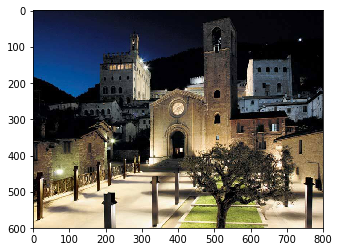

In [49]:
img = load_img("data/style_transfer/Gubbio.jpg")
plt.imshow(img)
img = get_image("data/style_transfer/Gubbio.jpg")
print img.shape

In [50]:
y = classify_img(img, vgg19_model)
print_predictions(y, to_print=10)

monastery 56.48%
church 14.15%
castle 13.55%
palace 9.68%
mosque 3.21%
bell_cote 1.40%
altar 0.35%
triumphal_arch 0.26%
dome 0.20%
vault 0.16%


Let's visualize the activation of intermediate layers using the input image:

In [51]:
# select all convolutional layers
selected_layers = [(l.name, l) for l in vgg19_model.layers if "conv" in l.name]
selected_layers

[('block1_conv1', <keras.layers.convolutional.Conv2D at 0x7f63b8415310>),
 ('block1_conv2', <keras.layers.convolutional.Conv2D at 0x7f62e26df7d0>),
 ('block2_conv1', <keras.layers.convolutional.Conv2D at 0x7f638e7fe8d0>),
 ('block2_conv2', <keras.layers.convolutional.Conv2D at 0x7f638e81c7d0>),
 ('block3_conv1', <keras.layers.convolutional.Conv2D at 0x7f638e7cda90>),
 ('block3_conv2', <keras.layers.convolutional.Conv2D at 0x7f638e7dfc50>),
 ('block3_conv3', <keras.layers.convolutional.Conv2D at 0x7f638e775f10>),
 ('block3_conv4', <keras.layers.convolutional.Conv2D at 0x7f638e788790>),
 ('block4_conv1', <keras.layers.convolutional.Conv2D at 0x7f638e742750>),
 ('block4_conv2', <keras.layers.convolutional.Conv2D at 0x7f638e6ec710>),
 ('block4_conv3', <keras.layers.convolutional.Conv2D at 0x7f638e6ecfd0>),
 ('block4_conv4', <keras.layers.convolutional.Conv2D at 0x7f638e712250>),
 ('block5_conv1', <keras.layers.convolutional.Conv2D at 0x7f638e6b6b90>),
 ('block5_conv2', <keras.layers.convol

In [52]:
def get_index_of_layer(layers, l_name):
    for i, l in enumerate(layers):
        if l_name == l[0]:
            return i
    else:
        return -1
    
print get_index_of_layer(selected_layers, "test") # not a correct layer name (-1)
print get_index_of_layer(selected_layers, "block5_conv4") # last layer (15)

-1
15


In [53]:
vgg19_activation_model = get_all_activation_layers(vgg19_model, selected_layers)
print vgg19_activation_model.summary()

[<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_conv4/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'block4_conv2/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'block4_conv3/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'block4_conv4/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_conv2/Relu:0' shape=(?, 14, 14, 512) d

In [54]:
features = classify_img(img, vgg19_activation_model)
print "features for", len(features), "convolutional layers"

features for 16 convolutional layers


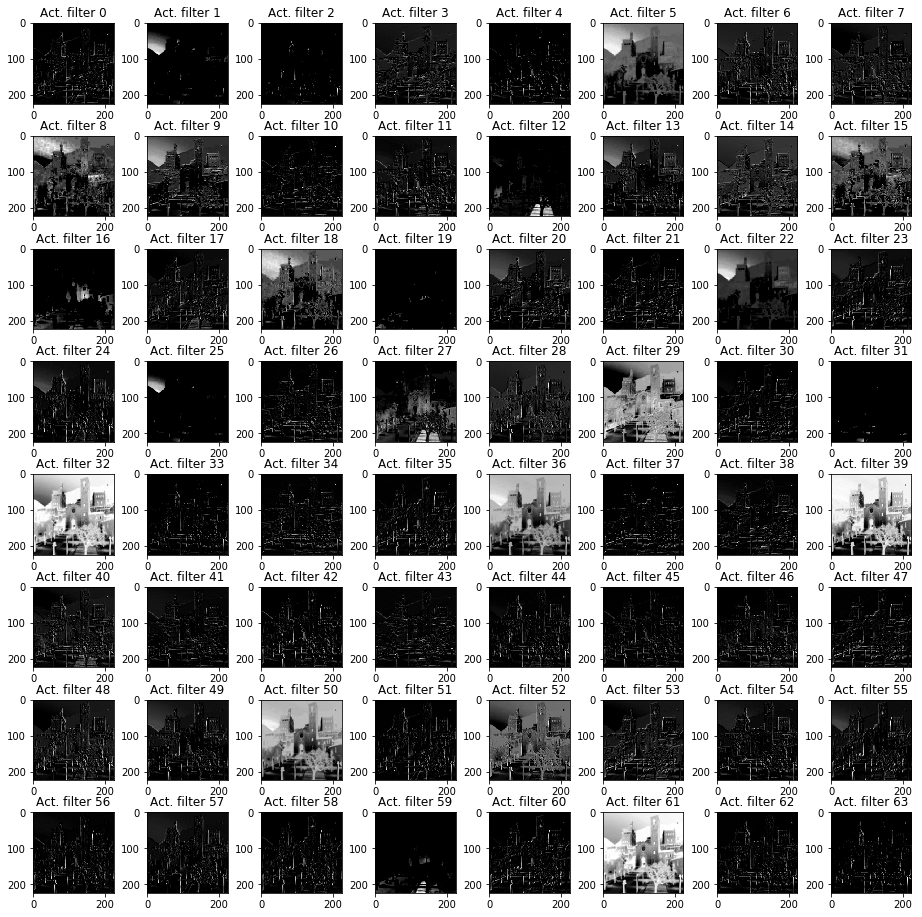

In [55]:
display_layer_activation(features[0], 64, plots_per_row=8)

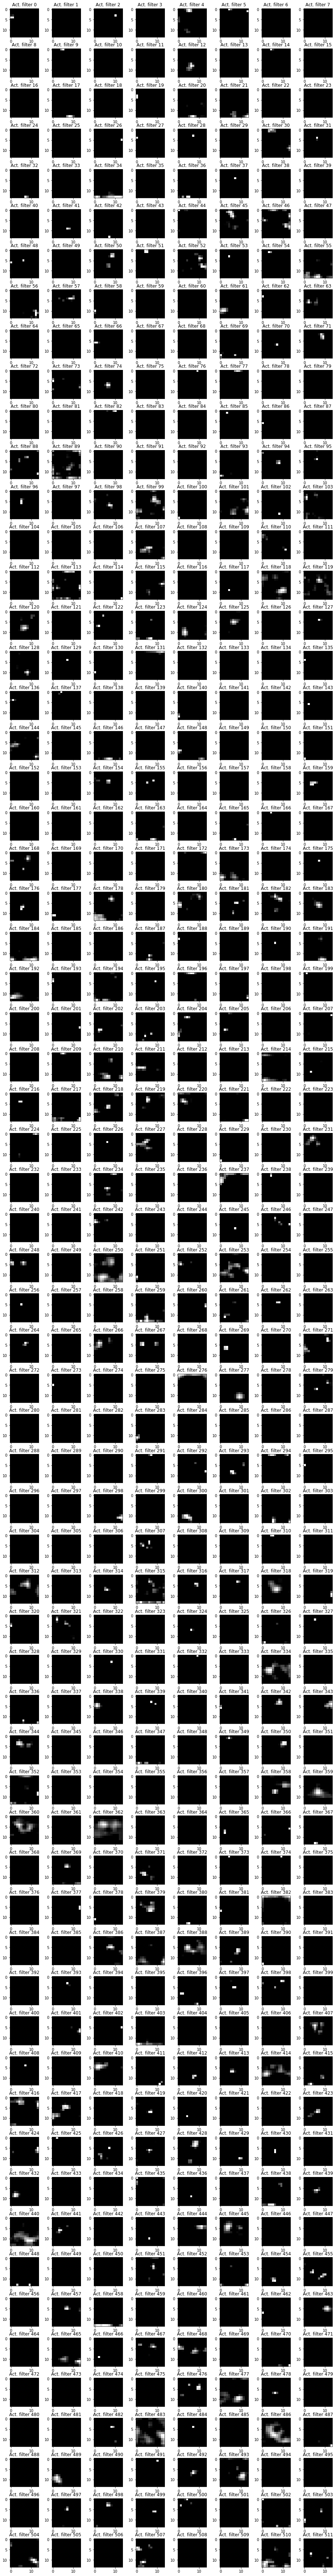

In [44]:
display_layer_activation(features[15], 512, plots_per_row=8)

## Show the filters for a specific convolution layer

We have 5 filters to plot


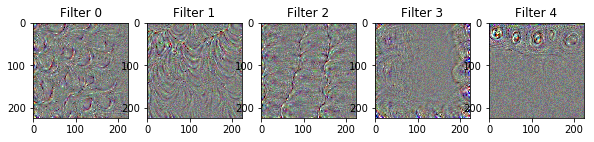

In [73]:
display_filter(vgg19_model.input,
               vgg19_model.get_layer("block5_conv1").output, 
               8,
               plots_per_row=8,
               grad_asc_gens=20)

## Creating a Feature Extractor

Let's now create a feature extractor by dropping the last dense layers used for classification, i.e., by getting the ouput of the last convolutional layer (block5_conv4):

In [45]:
vgg19_fe_model = get_feature_extractor(vgg19_model, layer_name="block5_conv4")

In [46]:
print img.shape
features = classify_img(img, vgg19_fe_model)
features.shape

(224, 224, 3)


(1, 14, 14, 512)

We can use this network for various purposes, mainly for generative networks, such as generative-adversarial networks (GANs), style transfer or others such as caption generation.